In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn


SOLUTION FOR THE TIME SERIES PREDICTION FOR THE SOLID TEMPERATURE TS0

The training data is given as a txt file with 3 columns: t, tf0, ts0. Each observation is given at a given constant distance between consecutive time steps. LSTM is used to give predictions.

In [ ]:
torch.manual_seed(128) 
training_set = pd.read_csv('TrainingData.txt')
training_set = training_set.iloc[:,2:3].values #we care only about the labels
testing_set=pd.read_csv('TestingData.txt')
print(training_set)
plt.plot(training_set, label = 'Ts0') #true function, the data is noiseless
plt.show()

Functions to normalize the data

In [3]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


In [4]:
def NormGaussData(data):
    return (data - np.mean(data)) / np.std(data)


In order to make predictions a new dataset was created in a way so that what it was given were consecutive temperature measurements for each starting time index of a fixed-length sequence of points.


We take sequences with 34 observations and based on them we predict the following one. 
(we use 34 because it's the length of Testing Data, the points we want to predict and it's the length of a full cycle of the temperature, time that it takes to start from low temperarure go up and come back)

In [5]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

seq_length=34

In [ ]:
#test_size=1
training_data=NormGaussData(training_set)
meantf=np.mean(training_set[:,0])
stdtf=np.std(training_set[:,0])
#testingX=(testing_set-np.min(training_set)) / (np.max(training_set) - np.min(training_set))
seq_len = seq_length #34
x, y = sliding_windows(training_data, seq_len)
#xtrain = x[:-test_size]
#ytrain = y[:-test_size]
#xtest = x[-test_size:]
#ytest = y[-test_size:]
print(len(x))
#print(xtrain)

train_size = int(len(y) * 1)
print(train_size)

In [7]:
dataX = (torch.Tensor(np.array(x))) #TODO: xtrain
dataY = (torch.Tensor(np.array(y)))
trainX = (torch.Tensor(np.array(x)))
trainY = (torch.Tensor(np.array(y)))

LSTM class for making predictions

In [8]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, 18)  # 20 for first model!

        self.fc = nn.Linear(18, num_classes)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        h_0 = (torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = (torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        xout, (h_out, c_out) = self.lstm(x, (h_0, c_0))  # al posto di c_out c'era _

        h_out = h_out.view(-1, self.hidden_size)
        c_out = c_out.view(-1, self.hidden_size)
        out = self.relu(h_out)
        # out=self.tanh(h_out)
        out = self.fc1(h_out)
        out = self.relu(out)  # relu
        # out = self.tanh(out)
        out = self.fc(out)  # Final Output
        # future=30
        """for i in range(future):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            ula, (h_out, c_out) = self.lstm(xout, (h_out, c_out))
            out = self.fc1(h_out)
            out = self.relu(out) #relu
            out = self.fc(out)
            out.append(out)"""

        return out

Hyperparameters for the model

In [9]:
num_epochs = 3500  # 3200/3000
learning_rate = 0.002  # 0.002

input_size = 1
hidden_size = 17  # 17
num_layers = 1  # 1

num_classes = 1

In [10]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.MSELoss()  # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)


In [ ]:
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    # print(outputs.shape, trainY.shape)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

In [12]:
additional_size=0
predict = np.zeros(len(testing_set)+additional_size) #np.zeros(test_size) #test_size
current_batch = torch.from_numpy(training_data[-seq_length:,:].reshape(1, seq_length, 1)).float()
#current_batch=dataX
count = 0
for i in range(len(testing_set)+additional_size): #test_size
    lstm.eval()
    with torch.no_grad():
      new_data = lstm(current_batch)
    predict[count] = (new_data.data.numpy())*(np.std(training_set))+np.mean(training_set)
    count += 1
    current_batch = torch.cat((current_batch[:, 1:, :], new_data.reshape(1, 1, 1)), dim=1)
#print(predict)

lstm.eval()

LSTM(
  (lstm): LSTM(1, 17, batch_first=True)
  (fc1): Linear(in_features=17, out_features=18, bias=True)
  (fc): Linear(in_features=18, out_features=1, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)

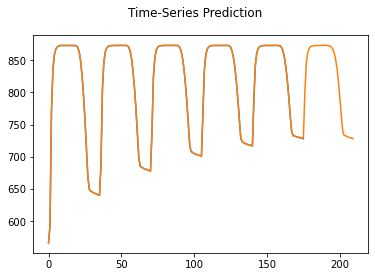

In [13]:
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = data_predict*(np.std(training_set))+np.mean(training_set)
dataY_plot = dataY_plot*(np.std(training_set))+np.mean(training_set)
y=torch.cat([torch.from_numpy(data_predict), torch.from_numpy(predict).reshape(-1,1)], 0)
y_plot=y.numpy()
#plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(y)
plt.suptitle('Time-Series Prediction')
plt.show()